reference: http://blog.yhat.com/posts/customer-segmentation-using-python.html

In [76]:
import pandas as pd

df_offer_info = pd.read_excel('./datasets/WineKMC.xlsx', sheet_name='OfferInformation')
df_offer_info.columns = ['offer_id', 'campaign', 'varietal', 'min_qty', 'discount', 'origin', 'past_peak']

df_offer_info.head()

,offer_id,campaign,varietal,min_qty,discount,origin,past_peak
0,1,January,Malbec,72,56,France,False
1,2,January,Pinot Noir,72,17,France,False
2,3,February,Espumante,144,32,Oregon,True
3,4,February,Champagne,72,48,France,True
4,5,February,Cabernet Sauvignon,144,44,New Zealand,True


In [77]:
df_transactions = pd.read_excel('./datasets/WineKMC.xlsx', sheet_name='Transactions')
df_transactions.columns = ['customer_name', 'offer_id']
df_transactions['n'] = 1
df_transactions.head()

,customer_name,offer_id,n
0,Smith,2,1
1,Smith,24,1
2,Johnson,17,1
3,Johnson,24,1
4,Johnson,26,1


### A quick K-Means primer
In order to segment our customers, we need a way to compare them. To do this we're going to use K-Means clustering. K-means is a way of taking a dataset and finding groups (or clusters) of points that have similar properties. K-means works by grouping the points together in such a way that the distance between all the points and the midpoint of the cluster they belong to is minimized.

### Clustering our customers
Okay, so how does clustering apply to our customers? Well since we're trying to learn more about how our customers behave, we can use their behavior (whether or not they purchased something based on an offer) as a way to group similar minded customers together. We can then study those groups to look for patterns and trends which can help us formulate future offers.
<br><br>
The first thing we need is a way to compare customers. To do this, we're going to create a matrix that contains each customer and a 0/1 indicator for whether or not they responded to a given offer. This is easy enough to do in Python:

In [78]:
# join the offers and transactions table
df = pd.merge(df_offer_info, df_transactions)

# create a 'pivot table' which will give us the number of times each customer responded to a given offer
matrix = df.pivot_table(index = ['customer_name'], columns=['offer_id'], values='n')

# a little tidying up. fill NA values with 0 and make the index into a column
matrix = matrix.fillna(0).reset_index()

# save a list of the 0/1 columns. we'll use these a bit later
x_cols = matrix.columns[1:]

Now to create the clusters, use 5 clusters. (rule of thumb is to have at least 7x as mamy records as do clusters)

In [79]:
from sklearn.cluster import KMeans

cluster = KMeans(n_clusters = 5)

# Slice matrix so we only include the 0/1 indicator columns in the clustering

matrix['cluster'] = cluster.fit_predict(matrix[matrix.columns[2:]])
matrix.cluster.value_counts()

0    28
4    19
1    19
3    17
2    17
Name: cluster, dtype: int64

### Visualizing the clusters
A really cool trick that the probably didn't teach you in school is Principal Component Analysis. There are lots of uses for it, but today we're going to use it to transform our multi-dimensional dataset into a 2 dimensional dataset. Why you ask? Well once it is in 2 dimensions (or simply put, it has 2 columns), it becomes much easier to plot!

Once again, scikit-learn comes to the rescue!

In [80]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 2)
matrix['x'] = pca.fit_transform(matrix[x_cols])[:,0]
matrix['y'] = pca.fit_transform(matrix[x_cols])[:,1]
matrix = matrix.reset_index()

customer_clusters = matrix[['customer_name', 'cluster', 'x', 'y']]
customer_clusters.head()

offer_id,customer_name,cluster,x,y
0,Adams,1,1.007580,0.108215
1,Allen,0,-0.287539,0.044715
2,Anderson,2,-0.392032,1.038391
3,Bailey,3,0.699477,-0.022542
4,Baker,3,0.088183,-0.471695


What we've done is we've taken those x_cols columns of 0/1 indicator variables, and we've transformed them into a 2-D dataset. We took one column and arbitrarily called it x and then called the other y. Now we can throw each point into a scatterplot. We'll color code each point based on it's cluster so it's easier to see them.

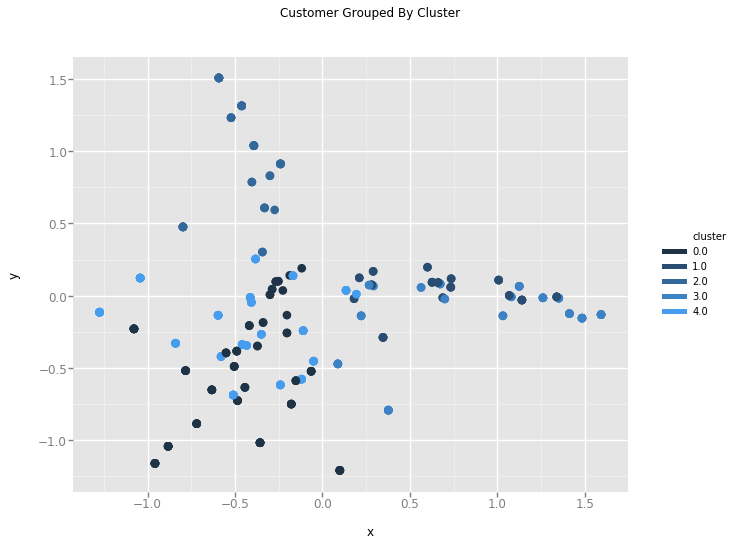

<ggplot: (-9223371904548395284)>

In [81]:
df = pd.merge(df_transactions, customer_clusters)
df = pd.merge(df_offer_info, df)

from ggplot import *

ggplot(df, aes(x='x', y='y', color='cluster')) \
        + geom_point(size= 75) + ggtitle('Customer Grouped By Cluster')

If you want to get fancy, you can also plot the centers of the clusters as well. These are stored in the KMeans instance using the cluster_centers_ variable. Make sure that you also transform the cluster centers into the 2-D projection.

In [82]:
# luster_centers = pca.transform(cluster.cluster_centers_)
# cluster_centers = pd.DataFrame(cluster_centers, columns=['x', 'y'])
# cluster_centers['cluster'] = range(0, len(cluster_centers))

# ggplot(df, aes(x='x', y='y', color='cluster')) + \
#     geom_point(size=75) + \
#     geom_point(cluster_centers, size=500) +\
#     ggtitle("Customers Grouped by Cluster")

### Digging deeper into the clusters
Let's dig a little deeper into the clusters. Take cluster 4 for example. If we break out cluster 4 and compare it to the remaining customers, we can start to look for interesting facets that we might be able to exploit.

As a baseline, take a look at the varietal counts for cluster 4 vs. everyone else. It turns out that almost all of the Cabernet Sauvignon offers were purchased by members of cluster 4. In addition, none of the Espumante offers were purchased by members of cluster 4.

In [83]:
df['is_4'] = df.cluster == 4
df.groupby('is_4').varietal.value_counts()

is_4   varietal          
False  Champagne             51
       Pinot Noir            39
       Prosecco              39
       Espumante             38
       Malbec                22
       Pinot Grigio          16
       Merlot                14
       Cabernet Sauvignon    12
       Chardonnay            11
True   Champagne             30
       Cabernet Sauvignon    20
       Malbec                10
       Merlot                 6
       Pinot Noir             5
       Chardonnay             4
       Prosecco               4
       Espumante              2
       Pinot Grigio           1
Name: varietal, dtype: int64

You can also segment out numerical features. For instance, look at how the mean of the min_qty field breaks out between 4 vs. non-4. It seems like members of cluster 4 like to by in bulk!

In [84]:
df.groupby('is_4')[['min_qty', 'discount']].mean()

,min_qty,discount
is_4,,
False,53.677686,57.685950
True,72.365854,64.780488
